# VolleyMap

With this project, we aim to identify and locate the referee area within frames captured from a volleyball game using a standard lateral camera setup.

Our approach follows a hierarchical detection strategy: we first segment and identify the volleyball court boundaries, then locate the net position, and finally determine the referee's location based on these reference points. This sequential method simplifies the detection process by establishing clear spatial relationships between court elements.

Once the referee region is isolated, our pipeline can seamlessly integrate with existing computer vision models specifically trained for referee gesture recognition, enabling automated interpretation of officiating signals from the extracted referee imagery.

# Setup

### Import Libraries

In [371]:
import cv2
import numpy as np
from functools import reduce

from matplotlib import pyplot as plt  # For plotting inline images

# Set default figure size for all plots
import pylab
pylab.rcParams['figure.figsize'] = (14.0, 6.0)

### Constants

We have chosen 3 clusters to segment the image due to courts we considered in the test. It is very easy to tweak this parameter to get better results for specific courts

In [372]:
# Set the path to the input image and the number of clusters for K-means segmentation.

# Path to the volleyball game frame to be processed.
IMAGE_PATH = 'data/duca.png'

# Number of color clusters to segment the court
N_CLUSTERS = 3

## Image preparation

We begin by loading the input image and enhancing its saturation to improve color differentiation, as our methodology relies on clustering pixels based on their color characteristics. This preprocessing step is crucial for achieving better segmentation accuracy in the subsequent color-based clustering algorithm.

In [373]:
# Load the image and convert it to RGB
image = cv2.imread(IMAGE_PATH)
original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to HSV for saturation enhancement
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Enhance saturation by multiplying the S channel
h, s, v = cv2.split(hsv)
s = cv2.multiply(s, 2.0)  # Increase saturation by 100%
s = np.clip(s, 0, 255).astype(np.uint8)  # Ensure values stay within valid range

# Merge channels back and convert to RGB
enhanced_hsv = cv2.merge([h, s, v])
enhanced_rgb = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2RGB)


Display the images

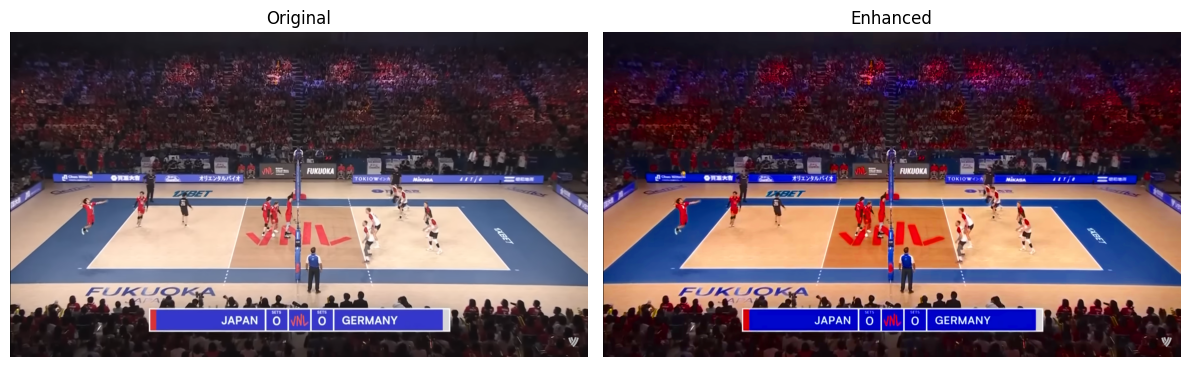

In [374]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original_rgb
axes[0].imshow(original_rgb)
axes[0].set_title('Original')
axes[0].axis('off')

# Display enhanced_rgb
axes[1].imshow(enhanced_rgb)
axes[1].set_title('Enhanced')
axes[1].axis('off')

# Show the figure
plt.tight_layout()
plt.show()

# Court recognition

As an initial step, this chapter focuses on recognizing and segmenting the volleyball court within the input image.

To accomplish this, we employ a color-based clustering approach to analyze the court's visual characteristics. Our methodology involves creating three distinct color clusters to capture the primary color regions present in the image. For each resulting cluster, we apply morphological preprocessing operations to eliminate noise, fill holes, and remove artifacts that could interfere with accurate segmentation.

Subsequently, we identify the largest connected component within each cluster, as this typically corresponds to the most significant region of that particular color. Finally, we perform a comparative analysis of these three primary components to determine which one accurately represents the actual volleyball court area, using geometric and spatial criteria to make this determination.

## K\-means

First, we apply K-means clustering segmentation to partition the image into distinct color-based clusters, enabling us to identify and separate the primary color regions within the volleyball court scene.

In [375]:
# Flatten the dimensions of the image for each channel for easier processing
# from [height, width, 3 (channels RGB)] (3 matrices) to [height * width, 3] (3 vectors)
pixels = enhanced_rgb.reshape((-1, 3)).astype(np.float32)

# Define the stop criteria for K-means:
# either at 100 max iterations or when the 1.0 (epsilon) accuracy is reached
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1.0)

# Apply K-means clustering with the specified number of clusters
# Parameters: data, k, bestLabels (none), criteria, attempts, flags (ten attempts, random centers)
_, labels, centers = cv2.kmeans(pixels, N_CLUSTERS, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Reshape the labels back to the original image dimensions
# This creates a map where each pixel is assigned to a cluster (0, 1, or 2)
labels_map = labels.reshape(enhanced_rgb.shape[:2])


In the following code block, we visualize the results of the K-means clustering algorithm.

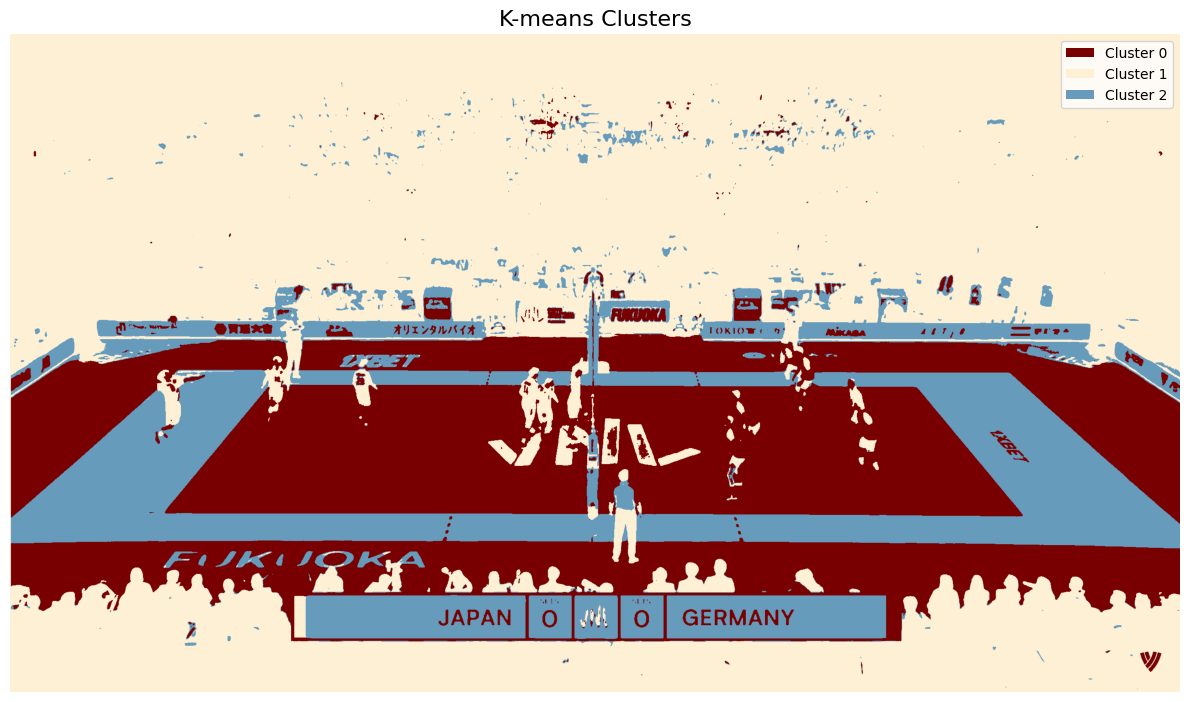

In [376]:
# Create a colored image showing all clusters
colored_clusters = np.zeros((labels_map.shape[0], labels_map.shape[1], 3), dtype=np.uint8)

# Define colors for each cluster (RGB format)
colors = [
    [120, 0, 0],        # Dark red for Cluster 0
    [253, 240, 213],    # Light beige for Cluster 1
    [102, 155, 188]     # Blue for Cluster 2
]

# Apply colors to each cluster
for i in range(N_CLUSTERS):
    mask = labels_map == i
    colored_clusters[mask] = colors[i]

# Create the plot with legend
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(colored_clusters)
ax.set_title('K-means Clusters', fontsize=16)
ax.axis('off')

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=np.array(colors[i])/255.0, label=f'Cluster {i}') 
                   for i in range(N_CLUSTERS)]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## Connected Components

The following functions will be used in subsequent code blocks.

In [377]:
def apply_hough(image):
    """
    Apply Hough line detection and morphological operations to detect and enhance lines.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input binary image (grayscale, single channel) for line detection
        
    Returns:
    --------
    numpy.ndarray
        Binary image with detected lines enhanced using morphological closing
        
    Description:
    ------------
    This function performs the following steps:
    1. Detects lines using Probabilistic Hough Line Transform with optimized parameters
    2. Draws detected lines on a blank canvas with white color and 2-pixel thickness
    3. Converts the colored line image back to grayscale binary format
    4. Applies horizontal morphological closing to connect nearby line segments and fill gaps
    
    The function is particularly effective for detecting horizontal structures and 
    connecting fragmented line segments through morphological operations.
    """
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=10, minLineLength=5, maxLineGap=200)
    h, w = image.shape
    lines_img = np.zeros((h, w, 3), dtype=np.uint8)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lines_img, (x1, y1), (x2, y2), (255, 255, 255), 2)

    gray = cv2.cvtColor(lines_img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Use horizontal rectangular kernel for connecting horizontal line segments
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closed


def fill_contours(mask, contours):
    """
    Fill contours by connecting border points and applying iterative Hough line detection.

    Parameters:
    -----------
    mask : numpy.ndarray
        Input binary mask (single channel, uint8) used as template for output dimensions
    contours : list
        List of contours detected by cv2.findContours, each contour is an array of points
        
    Returns:
    --------
    numpy.ndarray
        Binary mask with filled contours, same dimensions as input mask
        
    Description:
    ------------
    This function performs comprehensive contour filling through:
    1. Drawing contour outlines as thin white lines on a black canvas
    2. Connecting gaps along image borders (top, bottom, left, right edges) 
       by drawing lines between contour points that intersect each border
    3. Applying Hough line detection twice iteratively to enhance and connect line structures
    4. Finding and completely filling the resulting closed contours
    
    The border connection step is crucial for handling contours that extend to image edges,
    ensuring they form closed shapes that can be properly filled. The double Hough application
    strengthens weak connections and bridges small gaps in the contour structure.
    """
    contour_img = np.zeros_like(mask)
    cv2.drawContours(contour_img, contours, -1, 255, 1)

    h, w = contour_img.shape

    # Connect gaps on top and bottom borders
    for y in [0, h - 1]:
        row = contour_img[y, :]
        on_indices = np.where(row > 0)[0]
        if len(on_indices) >= 2:
            for i in range(len(on_indices) - 1):
                x1, x2 = on_indices[i], on_indices[i + 1]
                if x2 - x1 > 1:  # Only connect if there's a gap
                    cv2.line(contour_img, (x1, y), (x2, y), 255, 1)

    # Connect gaps on left and right borders
    for x in [0, w - 1]:
        col = contour_img[:, x]
        on_indices = np.where(col > 0)[0]
        if len(on_indices) >= 2:
            for i in range(len(on_indices) - 1):
                y1, y2 = on_indices[i], on_indices[i + 1]
                if y2 - y1 > 1:  # Only connect if there's a gap
                    cv2.line(contour_img, (x, y1), (x, y2), 255, 1)
    
    # Apply Hough line detection twice for robust line enhancement and gap filling
    closed = apply_hough(apply_hough(contour_img))

    # Find final contours and fill them completely
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(mask)
    cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)
        
    return filled

### Field Identification

We have the clusters of the image. So, we have to find the connected components of the clusters and elaborate them.

In detail, for each cluster we apply an horizontal gaussian blur and a treshold, in order to smooth the image and horizontal areas.
Then, we remove the remaining horizontal artifacts from the clusters.

Given a elaburated cluster, we search for the connected components, take the biggest one for each cluster and fill its holes, using its contour. 

In [378]:
# Initialize lists to store processing results for each cluster
filled_components = []  # Final filled components for comparison
components = []         # Largest connected components (binary masks)
masks = []             # Original cluster masks
binaries = []          # Thresholded binary masks
closeds = []           # Morphologically processed masks

# Process each cluster to find the largest connected component
# This involves preprocessing to remove noise and artifacts, then filling holes
for i in range(N_CLUSTERS):
  
  # Create binary mask for the current cluster (convert boolean to 0-255 range)
  mask = ((labels_map == i).astype(np.uint8)) * 255
  masks.append(mask)
  
  # Apply horizontal Gaussian blur to remove small artifacts
  # Large horizontal kernel (151x1) smooths out noise like players, net details, etc.
  # while preserving major horizontal structures like court boundaries
  blurred = cv2.GaussianBlur(mask, (151, 1), 0)
  
  # Apply binary threshold to create clean binary image
  # Pixels < 127 become 0 (black), >= 127 become 255 (white)
  _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
  binaries.append(binary)
  
  # Remove horizontal artifacts using morphological operations
  # Horizontal rectangular kernel (50x1) targets small horizontal noise
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
  
  # Opening: erosion followed by dilation - removes small objects
  opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
  
  # Closing: dilation followed by erosion - fills small gaps
  closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
  closeds.append(closed)
  
  # Find connected components and extract the largest one
  # This identifies separate regions and selects the most significant area
  num_labels, labels_im = cv2.connectedComponents(closed)
  component_mask = np.zeros_like(closed)
  
  if num_labels > 1:  # Ensure we have components beyond background (label 0)
    # Count pixels for each component (excluding background at index 0)
    areas = np.bincount(labels_im.flatten())[1:]
    
    # Find the component with maximum area
    max_label = np.argmax(areas) + 1  # +1 to account for background exclusion
    
    # Create mask containing only the largest component
    component_mask = (labels_im == max_label).astype(np.uint8) * 255
  
  # Store the largest component for later comparison
  components.append(component_mask)
  
  # Find contours of the largest component to prepare for hole filling
  # RETR_EXTERNAL gets only outer contours, ignoring holes
  contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  # Fill any holes within the component using custom fill_contours function
  # This ensures we have solid regions without internal gaps
  filled = fill_contours(component_mask, contours)
  filled_components.append(filled)

Visualization of processing steps for each cluster


Cluster 0 processing steps:


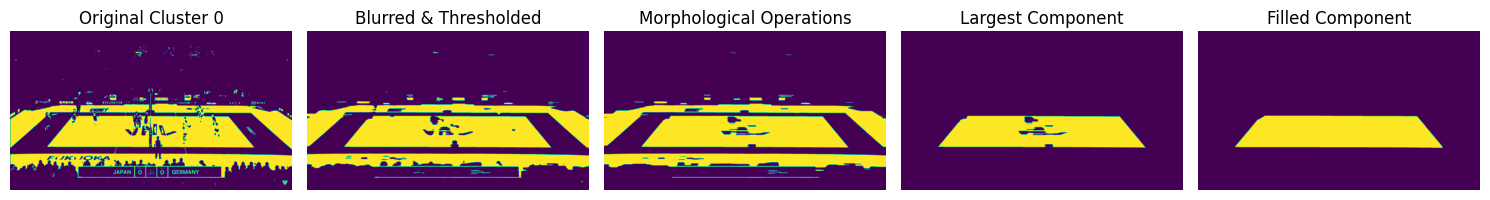


Cluster 1 processing steps:


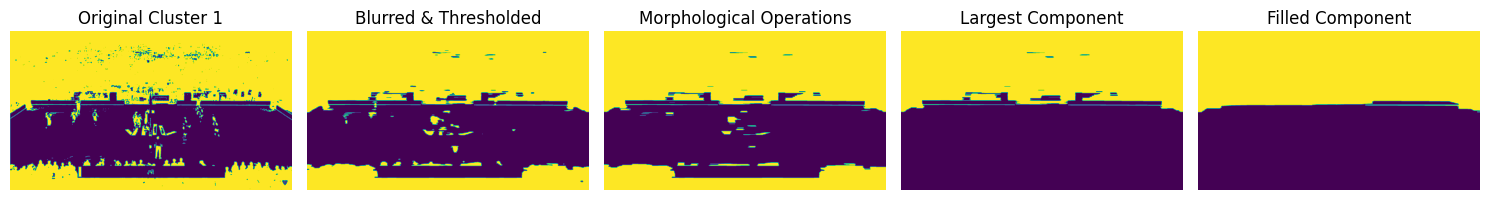


Cluster 2 processing steps:


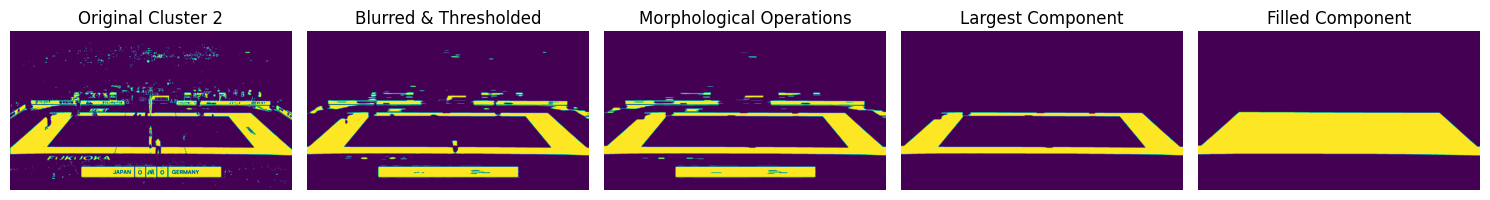

In [379]:
plt.ioff()

for i in range(N_CLUSTERS):
  print(f"\nCluster {i} processing steps:")

  plt.figure(figsize=(15, 4))
  plt.subplot(1, 5, 1)
  plt.imshow(masks[i])
  plt.title(f'Original Cluster {i}')
  plt.axis('off')

  plt.subplot(1, 5, 2)
  plt.imshow(binaries[i])
  plt.title(f'Blurred & Thresholded')
  plt.axis('off')

  plt.subplot(1, 5, 3)
  plt.imshow(closeds[i])
  plt.title(f'Morphological Operations')
  plt.axis('off')

  plt.subplot(1, 5, 4)
  plt.imshow(components[i])
  plt.title(f'Largest Component')
  plt.axis('off')
  
  plt.subplot(1, 5, 5)
  plt.imshow(filled_components[i])
  plt.title(f'Filled Component')
  plt.axis('off')
  
  plt.tight_layout()
  plt.show()

plt.ion()

Now that we have the largest connected and filled component for each cluster, we compare them to identify which one represents the actual volleyball field.

To accomplish this, we need to filter out clusters that contain holes. This is achieved by removing pixels from each component that belong to other clusters, allowing holes that may have been inadvertently filled in previous steps to be properly recognized. For example, the surrounding court area might initially appear as a valid component, but it contains a "field-shaped hole" in its center.

The hole detection process works as follows:
1. For each component under analysis, we create a union of all other cluster masks
2. We apply a logical operation (A AND NOT B) where A is the filled component and B is the union of other clusters
3. We calculate a similarity metric: `similarity = 1 - (pixels_removed / total_white_pixels)`
4. Components with similarity > 0.9 are considered hole-free and valid candidates

Finally, among the valid candidates (those without significant holes), we select the component whose center of mass is closest to the expected field center. The expected center is positioned at the horizontal center of the image and at 2/3 of the image height (lower portion), accounting for the typical camera perspective in volleyball broadcasts where the field appears in the lower part of the frame.

In [380]:
# Convert filled components from [0, 255] domain to [False, True] boolean domain
components = list(map(lambda x: x > 0, components))

# Initialize variables for field selection algorithm
min_distance = float('inf')
final_mask = None
to_removes = []
similarities = []  # To store similarity metrics for each component

# Define the expected field center position for comparison
# The field typically appears in the lower portion due to camera perspective,
# so we set the checking center at 2/3 of image height (this can be changed based on prior knowledge of the actual scenario)
W = original_rgb.shape[1]
H = original_rgb.shape[0]
CENTER = (W // 2, 2 * H // 3)

# Select the best connected component representing the volleyball field
# Criteria:
#   a) no significant holes from other clusters
#   b) closest to expected center
for i in range(N_CLUSTERS):
  filled = filled_components[i]
  
  # Remove areas of other clusters from current component to detect holes
  # This reveals whether the component contains "field-shaped holes"
  # Logic: A AND NOT B, where A = current component, B = union of other clusters
  other_masks = components.copy()
  del other_masks[i]
  
  # Create union of all other cluster masks (areas to be removed)
  to_remove = reduce(lambda x, y: x | y, other_masks)
  to_removes.append(to_remove)
  
  # Apply hole detection: remove other cluster areas and convert back to [0, 255]
  mask = (filled & (~to_remove)) * 255
  
  # Calculate similarity metric: 1 - (pixels_removed / total_white_pixels)
  # High similarity (>0.9) indicates minimal holes, making it a valid field candidate
  similarities.append(1 - np.sum(filled > mask) / np.sum(filled > 0))
  
  # Only consider components without significant holes (similarity > 90%)
  if similarities[i] > 0.9:
    # Calculate center of mass of the component
    M = cv2.moments(filled)
    if M["m00"] != 0:
      cx = int(M["m10"] / M["m00"])
      cy = int(M["m01"] / M["m00"])
      
      # Calculate Euclidean distance from component center to expected field center
      distance = np.linalg.norm(np.array([cx, cy]) - np.array([CENTER[0], CENTER[1]]))
      
      # Select component with minimum distance to expected center
      if distance < min_distance:
        min_distance = distance
        final_mask = filled


## Result Visualization

Visualization functions to display and analyze processing results for individual clusters.

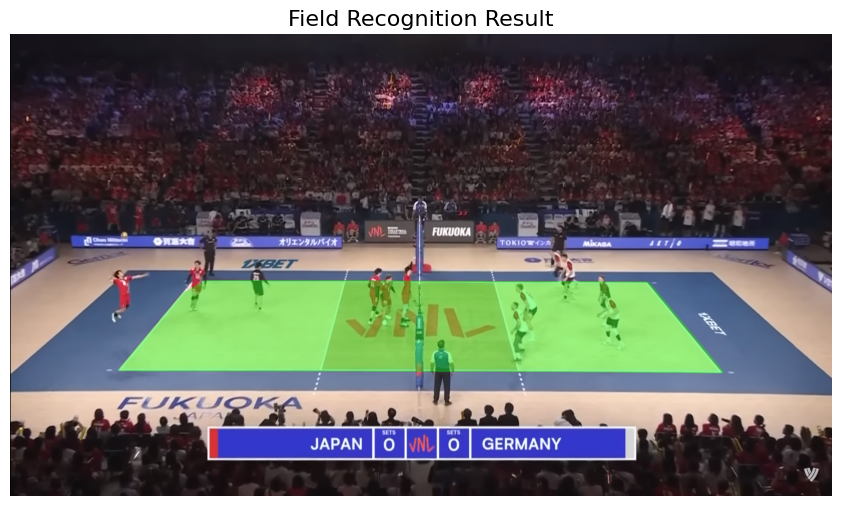

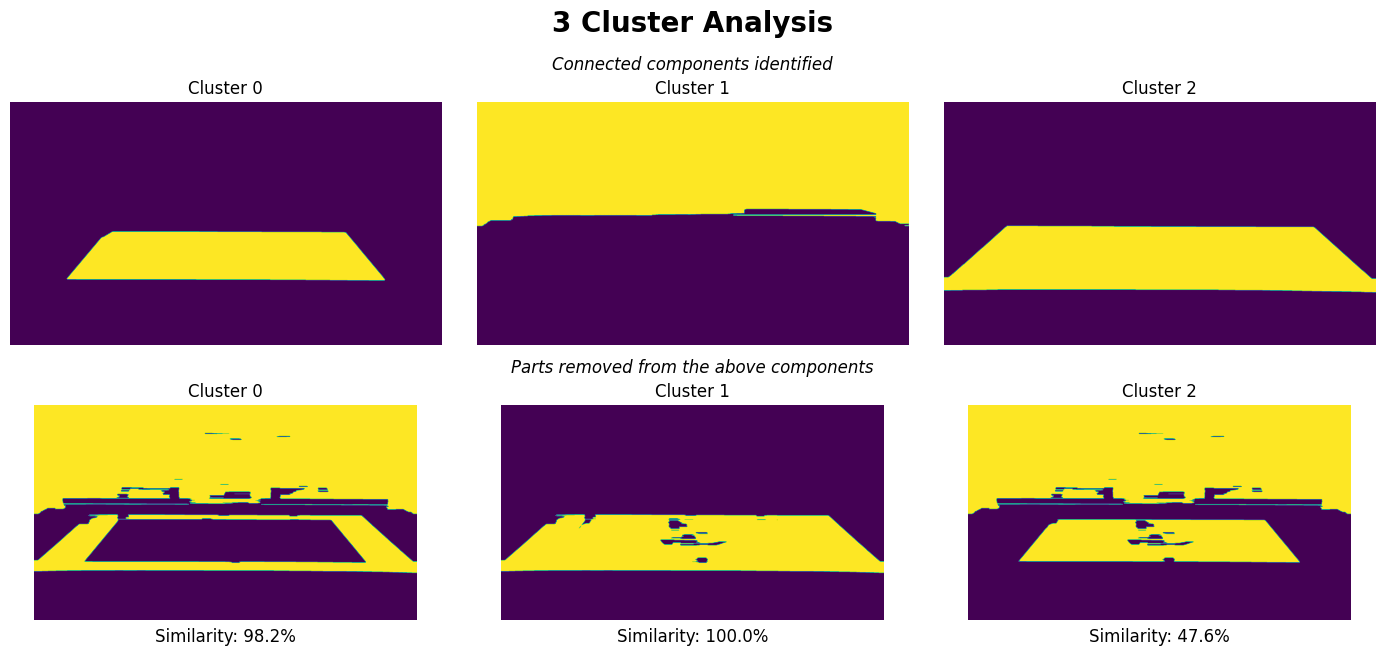

In [381]:
plt.ioff()

# Create main figure with 2 rows for displaying results
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(14, 6))
fig.suptitle(f'{N_CLUSTERS} Cluster Analysis', fontweight='bold', size=20, y=1.07)  

# Remove the default axes to make room for subfigures
for ax in axs:
  ax.remove()
  
# Get the gridspec from the removed axes to create subfigures
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

# Configure the first subfigure for connected components visualization
subfigs[0].suptitle('Connected components identified', fontstyle='italic')
axs_top = subfigs[0].subplots(1, N_CLUSTERS)

# Display filled components
for i in range(N_CLUSTERS):
  axs_top[i].imshow(filled_components[i])
  axs_top[i].set_title(f'Cluster {i}')
  axs_top[i].axis('off')

# Configure the second subfigure for removed parts visualization
subfigs[1].suptitle('Parts removed from the above components', fontstyle='italic')
axs_bottom = subfigs[1].subplots(1, N_CLUSTERS)

# Calculate similarities for each cluster and display removed parts
for i in range(N_CLUSTERS):
  filled = filled_components[i]
  
  # Display removed parts
  axs_bottom[i].imshow(to_removes[i])
  axs_bottom[i].set_title(f'Cluster {i}')
  axs_bottom[i].axis('off')
  axs_bottom[i].text(0.5, -0.1, f'Similarity: {int(similarities[i] * 1000) / 10}%', 
             transform=axs_bottom[i].transAxes, ha='center', fontsize=12)

plt.ion()

# Create the field visualization with green overlay
overlay = np.zeros_like(original_rgb, dtype=np.uint8)
overlay[:] = (0, 255, 0)  # Pure green

# Alpha blend the green overlay with the original image
alpha = 0.4  # 0 = transparent, 1 = solid green
blended = cv2.addWeighted(original_rgb, 1 - alpha, overlay, alpha, 0)

# Apply the final mask to show only the field area
output = np.where(final_mask[:, :, np.newaxis] == 255, blended, original_rgb)

# Create and display the result figure
res_fig, res_ax = plt.subplots(1, 1, figsize=(14, 6))
res_ax.imshow(output)
res_ax.set_title('Field Recognition Result', fontsize=16)
res_ax.axis('off')

# Collect all figures for display
figures = [res_fig, fig]

# Display and close figures to free memory
for figure in figures:
  display(figure)
  plt.close(figure)

# Net Recognition

First, we crop the original image to focus on the volleyball court area. Since the net extends slightly above the field level, we expand the region upward to ensure the net area is included in our analysis.

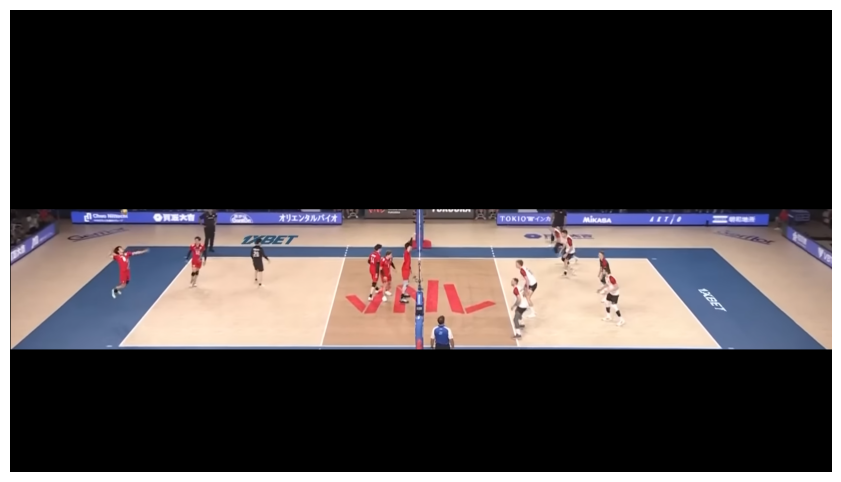

In [397]:
# Create a new empty mask with the same dimensions as final_mask
extended_mask = np.zeros_like(final_mask)

# Find the vertical bounds (y_min, y_max) of the court region in final_mask
ys, xs = np.where(final_mask > 0)
if len(ys) > 0:
    y_min = ys.min()  # Top edge of the court
    y_max = ys.max()  # Bottom edge of the court
    h_region = y_max - y_min + 1  # Height of the court region
    
    # Calculate the new extended y_min by moving upward by half the court height
    # This extends the region above the court to capture the net area
    new_y_min = max(0, int(y_min - h_region / 2))
    
    # Set the extended region to white (255) to create the mask
    # This fills from the new extended top to the original court top
    extended_mask[new_y_min:y_min, :] = 255
    
    # Also include the original court area in the extended mask
    extended_mask[y_min:y_max+1, :] = 255

# Convert the grayscale mask to a 3-channel color mask for bitwise operations
extended_mask = cv2.cvtColor(extended_mask, cv2.COLOR_GRAY2BGR)

# Apply the extended mask to the original image to isolate the court and net area
masked_image = cv2.bitwise_and(original_rgb, extended_mask)

# Display the masked image showing the court with extended area above for net detection
plt.imshow(masked_image)
plt.axis('off')
plt.show()

Then we attempt to identify the volleyball net. To accomplish this, we detect all vertical lines within the court region using the Hough Line Transform, filter them based on angle constraints and positional criteria, and retain the longest vertical line segment, which typically corresponds to the net structure.

Net line coordinates: [[1270  964]
 [1276  622]], Length: 342.0526275297414


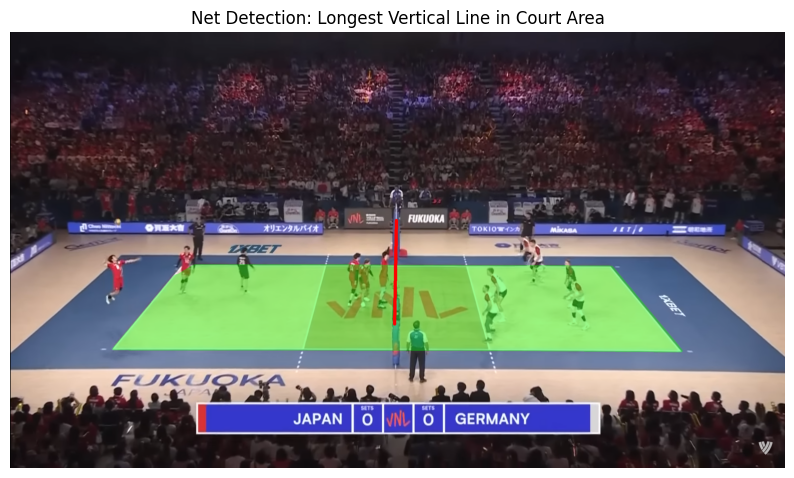

In [399]:
# Step 1: Preprocess the image for edge detection
gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)  # Convert masked court region to grayscale
edges = cv2.Canny(gray, 50, 150)  # Apply Canny edge detection to identify potential line segments

# Step 2: Detect line segments using Probabilistic Hough Line Transform
# Parameters: rho=1 (distance resolution), theta=π/180 (angle resolution in radians),
# threshold=100 (minimum votes), minLineLength=120 (minimum line length),
# maxLineGap=1000 (maximum gap between line segments to connect them)
all_lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=120, maxLineGap=1000)

# Create an empty image to visualize detected vertical lines
vertical_lines_img = np.zeros_like(edges)

# Step 3: Create overlay image for visualization
overlay = output.copy()  # Copy the field recognition result as base for visualization

# Step 4: Filter detected lines to identify near-vertical lines representing the net
lines = []
W = original_rgb.shape[1]  # Image width for boundary checking

# Filter lines based on angle and position constraints
if all_lines is not None:
    for line in all_lines:
        x1, y1, x2, y2 = line[0]
        # Calculate line angle in degrees (0° = horizontal, 90° = vertical)
        angle = abs(np.degrees(np.arctan2(y2 - y1, x2 - x1)))
        
        # Filter criteria:
        # - Near-vertical: angle between 80° and 100°
        # - Not at image edges: line center must be >100px from left edge and >100px from right edge
        # This ensures we capture the net (vertical) while excluding court boundary lines
        if 80 < angle < 100 and (x1 + x2) > 100 and (2 * W - (x1 + x2)) > 100:
            p1 = np.array([x1, y1])  # Start point
            p2 = np.array([x2, y2])  # End point
            l = np.array([p1, p2])   # Line segment as point pair
            lines.append(l)

# Step 5: Calculate lengths of all detected vertical line segments
def line_length(line):
    """Calculate the Euclidean length of a line segment"""
    diffs = np.diff(line, axis=0)  # Calculate point differences
    segment_lengths = np.linalg.norm(diffs, axis=1)  # Euclidean distance
    return np.sum(segment_lengths)  # Total length (for multi-segment lines)

lengths = [line_length(line) for line in lines]

# Step 6: Identify the longest vertical line as the volleyball net
# The net typically appears as the longest continuous vertical structure in the court area
longest_index = np.argmax(lengths)
longest_line = lines[longest_index]
longest_length = lengths[longest_index]

print(f"Net line coordinates: {longest_line}, Length: {longest_length}")

# Draw the detected net line on the overlay image with a thick blue line
cv2.line(overlay, longest_line[0], longest_line[1], (255, 0, 0), 10)

# Step 7: Visualize the net detection result
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.title('Net Detection: Longest Vertical Line in Court Area')
plt.axis('off')
plt.show()


# Referee Area Recognition

Finally, having determined the net's position and length, we define the referee area by creating a rectangular region above the net with dimensions proportional to the net length. The rectangle width is set to half the net length, while the height is set to two-thirds of the net length, positioned directly above the net's top point to capture the typical referee positioning area during volleyball matches.

Top pixel coordinates: [1276  622]


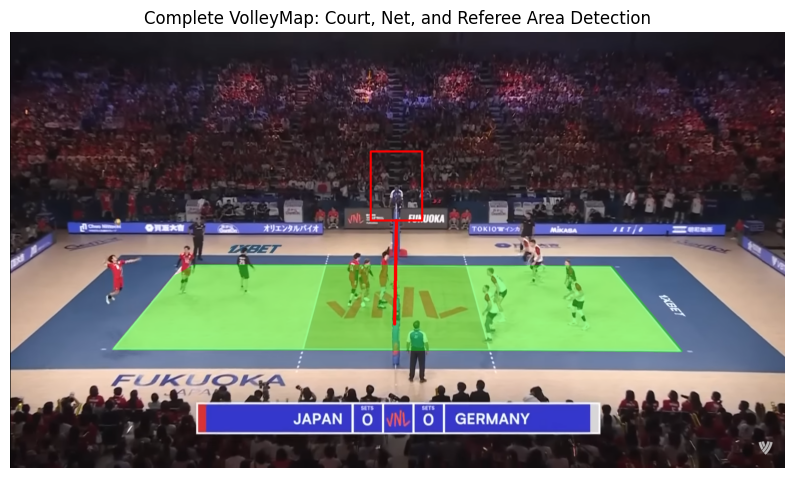

In [401]:
# Get the top point of the detected net line (point with smaller y-coordinate)
top_pixel = longest_line[0] if longest_line[0][1] < longest_line[1][1] else longest_line[1]
print(f"Top pixel coordinates: {top_pixel}")

# Define the referee area dimensions based on the net length
# Width: half the net length to capture the referee's lateral movement range
rect_width = int(longest_length/2)  
# Height: two-thirds of the net length to provide adequate vertical coverage
rect_height = int(longest_length/1.5)  

# Calculate the referee area rectangle coordinates
# The rectangle is positioned directly above the net's top point
final = overlay.copy()
top_left = (top_pixel[0] - rect_width // 2, top_pixel[1] - rect_height)
bottom_right = (top_pixel[0] + rect_width // 2, top_pixel[1])

# Draw the referee area rectangle with blue color and 5-pixel thickness
cv2.rectangle(final, top_left, bottom_right, (255, 0, 0), 5)

# Visualize the final result showing the court, net, and referee area
plt.figure(figsize=(10, 6))
plt.imshow(final)
plt.title('Complete VolleyMap: Court, Net, and Referee Area Detection')
plt.axis('off')
plt.show()